# Cuaderno de exploración de los modelos ARIMA
Como funcionan, adicionalmente explroación de las librerias statsmodels y pmdarima.

Empezamos revisando la cantidad de valores nulos que tenemos en un dataframe cualquiera, en este caso, tomamos el primero.

In [93]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Cargamos los datos
path = '../datos/separados_por_estacion/MAGDALENA_MEDIO/'

file = os.listdir(path)[10]
col = file.split('.')[0]
df = pd.read_csv(path+file)

# Buscar columnas con valores nulos
col_null = df.columns[df.isnull().any()].tolist()
print('Cantidad de valores nulos:',df[col_null].isnull().sum())

Cantidad de valores nulos: 23050250    21
dtype: int64


Empezamos revisando si la serie de tiempo es estacionaria

23050250.csv


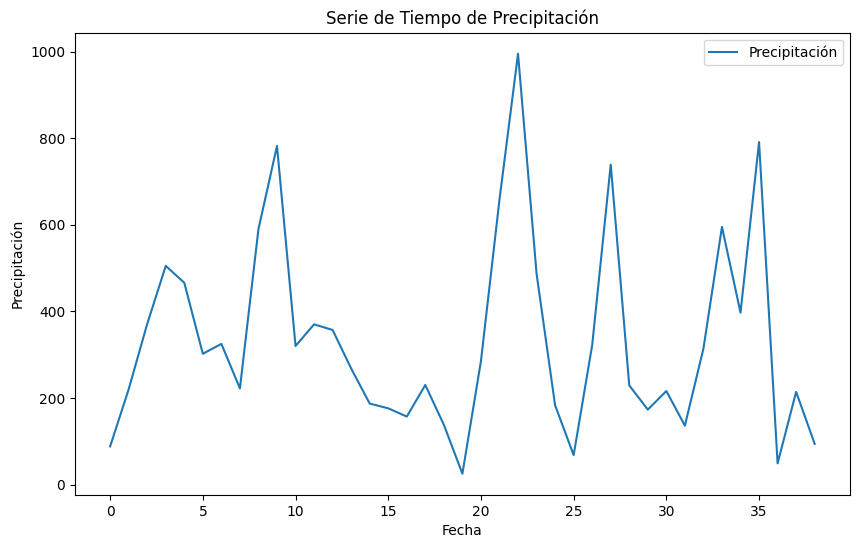

In [96]:
#hacemos un ls de la carpeta
file_test = os.listdir(path)[10]
print(file_test)
col = file_test.split('.')[0]

df = pd.read_csv(path+file_test)

df[col] = df[col].replace(-99999.0, np.nan)

# Graficar la serie de tiempo con el eje x siendo cada dato mensual
# agregamos el valor de cada thickness
plt.figure(figsize=(10, 6))
plt.plot(df[col][0:48], label='Precipitación')
plt.title('Serie de Tiempo de Precipitación')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()
plt.show()

Visualmente podemos apreciar como si se ve una tendencia estacional que se repite cada 12 datos(es decir cada año), pero igualmente le pasamos una Prueba de Dickey-Fuller Aumentada (ADF) utilizando la libreria statsmodels

In [52]:
!pip install statsmodels
!pip install pmdarima

In [97]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF
result = adfuller(df[col].dropna())

# Mostrar los resultados
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.404066776992562
p-value: 0.010821014248349088
Critial Values:
   1%, -3.462980134086401
Critial Values:
   5%, -2.875885461947131
Critial Values:
   10%, -2.5744164898444515


Dados los valores que encontramos, ADF es más negativa que todos los valores críticos (tanto al 1%, 5% y 10%) y un el valor p es extremadamente bajo, podemos concluir que la serie de tiempo es estacionaria, razon por la cual no necesitamos diferenciación y por lo mismo podemos asignar el valor 0 al término D del modelo ARIMA. Ahora se procede a identificar el grado de autocorrelacion parcial para hayar el valor del término P. Realizar este proceso es importante porque la PACF muestra la correlación entre una serie de tiempo y sus propios retrasos, eliminando la influencia de los términos intermedios.

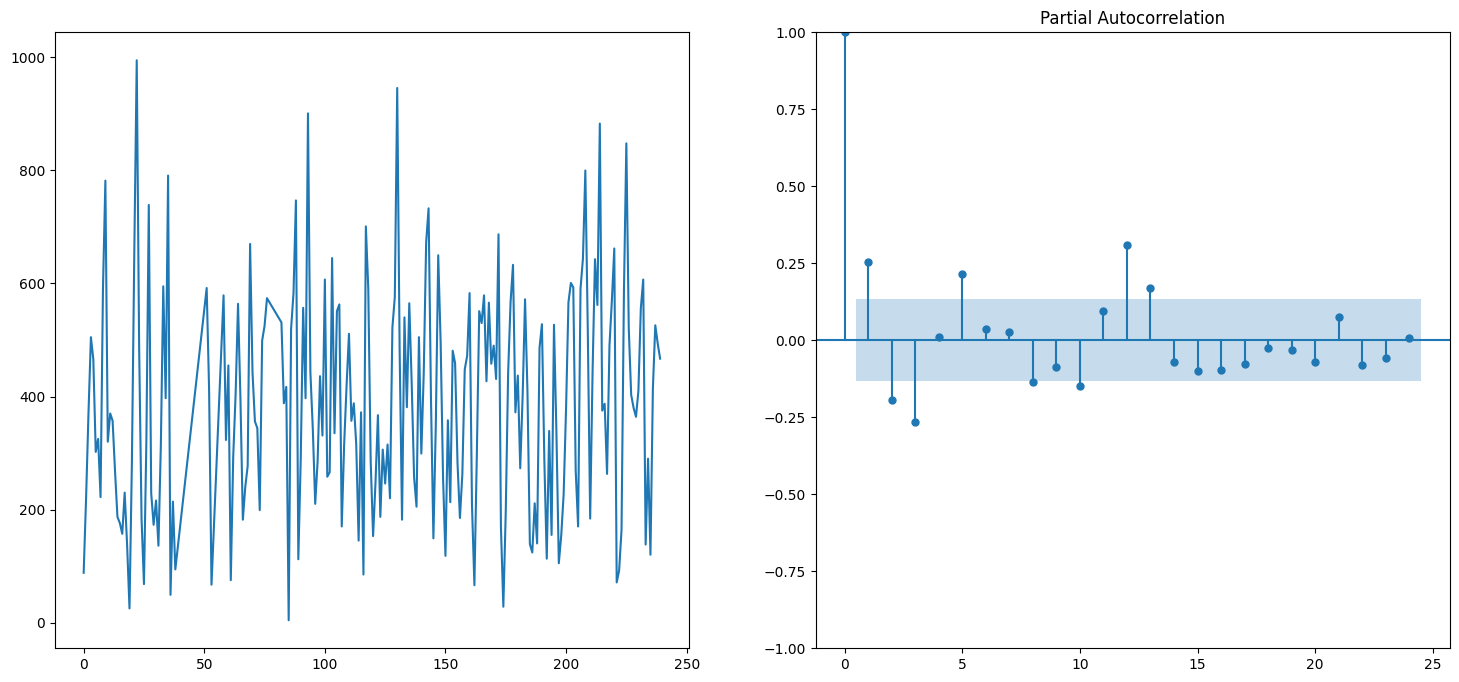

In [98]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(df[col].dropna())
plot_pacf(df[col].dropna(), ax=ax[1])
plt.show()

ADF Statistic: -3.404066776992562
p-value: 0.010821014248349088


<Figure size 1000x600 with 0 Axes>

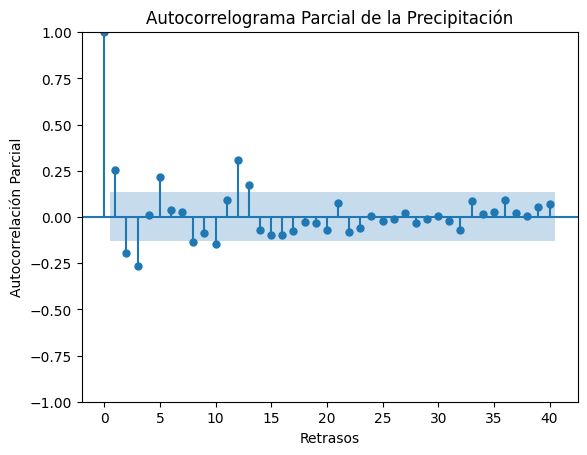

In [100]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima

df_ARIMA = df[["Fecha", col]]
df_ARIMA['Fecha'] = pd.to_datetime(df_ARIMA['Fecha'])
df_ARIMA.set_index('Fecha', inplace=True)

df_ARIMA = df_ARIMA.dropna()
df_ARIMA

result = adfuller(df_ARIMA[col])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Graficar la PACF
plt.figure(figsize=(10, 6))
plot_pacf(df_ARIMA[col], lags=40)
plt.xlabel('Retrasos')
plt.ylabel('Autocorrelación Parcial')
plt.title('Autocorrelograma Parcial de la Precipitación')
plt.show()

In [101]:
model = auto_arima(df_ARIMA[col], seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2937.752, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2893.237, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2899.496, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3282.484, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2925.102, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2892.774, Time=1.11 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2896.963, Time=2.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2897.507, Time=0.34 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2895.879, Time=0.93 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2894.051, Time=1.57 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2893.852, Time=0.78 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2892.596, Time=0.52 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2893.061, Time=0.22 sec
 ARIMA(0,0,1)(2,0,1)[12]

In [102]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  219
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1441.298
Date:                             Thu, 06 Jun 2024   AIC                           2892.596
Time:                                     19:46:35   BIC                           2909.542
Sample:                                          0   HQIC                          2899.440
                                             - 219                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    209.1281     34.624      6.040      0.000     141.266     276.991
ma.L1          0.1583      

In [103]:
# Obtenemos los valores de p, d, q, P, D y Q
p_value = model.order[0]
d_value = model.order[1]
q_value = model.order[2]
P_value = model.seasonal_order[0]
D_value = model.seasonal_order[1]
Q_value = model.seasonal_order[2]

print(f'El valor p sugerido es: {p_value}')
print(f'El valor d sugerido es: {d_value}')
print(f'El valor q sugerido es: {q_value}')
print(f'El valor P sugerido es: {P_value}')
print(f'El valor D sugerido es: {D_value}')
print(f'El valor Q sugerido es: {Q_value}')

El valor p sugerido es: 0
El valor d sugerido es: 0
El valor q sugerido es: 1
El valor P sugerido es: 2
El valor D sugerido es: 0
El valor Q sugerido es: 0


Entrenamos el modelo y procedemos a realizar la imputacion de los valores faltantes en la serie de tiempo.

In [104]:
# Ajustamos el modelo ARIMA con los 6 valores encontrados
model = ARIMA(df_ARIMA[col], order=(p_value, d_value, q_value), seasonal_order=(P_value, D_value, Q_value, 12))
model_fit = model.fit()

In [110]:
df_n = df.copy()
# Preparar los datos
df_n['Fecha'] = pd.to_datetime(df_n['Fecha'])

# Entrenar el modelo ARIMA con los datos no nulos
model = ARIMA(df_n[col].dropna(), order=(p_value, d_value, q_value))
model_fit = model.fit()

# Crear una copia del DataFrame original para no modificar los datos originales
df_fill = df_n.copy()

# Usar el modelo entrenado para predecir los valores nulos
for i in df_fill[df_fill[col].isna()].index:
    df_fill.loc[i, col] = model_fit.predict(start=i, end=i).values[0]

# # Usar el modelo entrenado para predecir los valores nulos
# for i in df_fill[df_fill[col].isna()].index:
#     df_fill.loc[i, col] = model_fit.predict(n_periods=1)

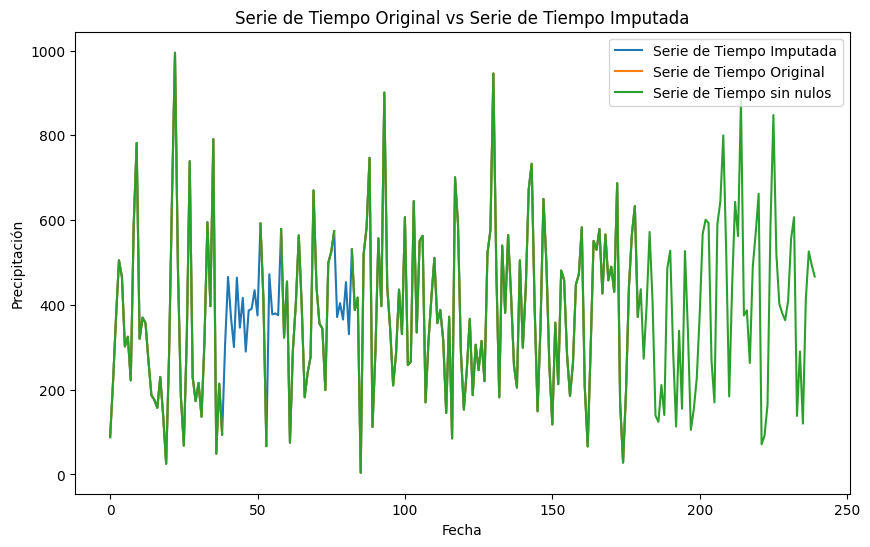

In [115]:
# seteamos el indice de la serie de tiempo
df_filled = df_fill.copy()
# utilizamos los datos originales para ver mejor los datos imputados
# para ello tomamos el dataframe original y renombramos la columna de precipitación
df_orig = df.copy()
df_orig = df_orig.rename(columns={col: 'Precipitación_original'})
df_orig = df_orig[['Precipitación_original']]

df_filled = df_filled.rename(columns={col: 'Precipitación_imputada'})

# cruzamos los datos originales con los datos imputados con join por fecha
df_filled = df_filled.join(df_orig, how='left')
df_filled

# Graficamos la serie de tiempo original y la serie de tiempo imputada, imprimos con los indices en als etiquetas rotados 90 grados
plt.figure(figsize=(10, 6))
plt.plot(df_filled['Precipitación_imputada'][0:180], label='Serie de Tiempo Imputada')
plt.plot(df_filled['Precipitación_original'][0:180], label='Serie de Tiempo Original')
plt.title('Serie de Tiempo Original vs Serie de Tiempo Imputada')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')

plt.legend()
plt.show()

Podemos observar como con el modelo ARIMA predecimos los datos faltantes de nuestra serie de tiempo para pdoer trabajar con ella mas adelante.

In [117]:
# contamos valores nulos en nuestro dataframe
print(df_filled.isnull().sum())

Fecha                      0
Mes                        0
Año                        0
Precipitación_imputada     0
Precipitación_original    21
dtype: int64


In [118]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               23050250   No. Observations:                  219
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1458.203
Date:                Thu, 06 Jun 2024   AIC                           2922.406
Time:                        20:01:02   BIC                           2932.573
Sample:                             0   HQIC                          2926.512
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        385.9283     16.900     22.836      0.000     352.805     419.051
ma.L1          0.2811      0.067      4.220      0.000       0.151       0.412
sigma2      3.555e+04   3662.449      9.706      0.0